### This notebook represents holding a Deribit coin Margin Perpetual, both Long and Short.  The Perpetuals are "created" from the spot index price which is accurate enough to demonstrate my point.

Because Deribit credits and debits UNREALISED profits and losses on a daily basis, a short perpetual position does not work to hedge a spot holding, and a long position does not match holding the index.

I take no account of Funding Fees since they are irrelevant for this exercise.

This is because the coin amounts credited or debited moves in price over the duration of the holding.  With other exchanges, the unrealised P&L will be taken account of for margin but not charged to the account until the trade is closed - which could be any time after the opening.

The result as can be seen from the below charts is that hedging 1 ETH for the period shown below results in a loss of both the initial ETH 1 you are attempting to hedge and a further $890.

This is because the 1 ETH you are trying to hedge is kept in the same account as the unrealised P&L is debited / credited to. Therefor in a rising market it gets eaten by the losses. You need the 1 ETH left untouched so that ir rises in price to exactly counteract the loss on the short contract, thus leaving you with the original $ amount of the 1 ETH as of the date the hedge was put on.

Note also that the long position does not reflect the index - unrealised profits accruing daily boost the profits in a rising market.

So if you want to hedge 1 ETH with a perpetual at Deribit you need to have a multi collateral account, deposit 1 ETH and short 1 ETH.  Which sounds acceptable until you realise that in a rising market a dollar debit arises on which you will be charged 0.01% daily.

Again, hardly ideal.

Unless of course I have made some error in my though process.  And yet the records of my actual account with Deribit support my conclusions.



In [1]:
#imports
import pandas as pd
import numpy as np
import ffn
import os
import sys
import pathlib
import datetime
from IPython.core.pylabtools import figsize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
%matplotlib inline

In [3]:
directory = r'C:\Users\agarn\OneDrive\Documents\Data\Funding_Rates\ETH_USD_ETH'
files = [x for x in pathlib.Path(directory).glob('*.csv') if x.is_file()]
names = [x.stem for x in files]
names

['deribit_ETH_USD_ETH_funding_rate_history']

In [4]:
files

[WindowsPath('C:/Users/agarn/OneDrive/Documents/Data/Funding_Rates/ETH_USD_ETH/deribit_ETH_USD_ETH_funding_rate_history.csv')]

In [5]:
# Read the CSV file, skipping the header row and assigning column names
df = pd.read_csv(files[0], skiprows=1, header=None, names=['date', 'rate', 'index'])

# Convert the date column to datetime format
df.date = pd.to_datetime(df.date, utc=True)

# Set the date column as the index
df.set_index(['date'], inplace=True)

# Remove duplicate indices, keeping the first occurrence
df = df[~df.index.duplicated(keep='first')]

# Sort the DataFrame by the index (date) in ascending order
df.sort_index(inplace=True)

# Optional: Filter the DataFrame by date range and calculate the percentage change
# df = df.loc['2019-05-01 07:00:00+00:00':'2023-05-31 23:00:00+00:00']
# df['rate_return'] = df['rate'].pct_change().fillna(0)

In [6]:
df.head()

rate   index
date                                       
2019-05-01 07:00:00+00:00 -0.000288  160.49
2019-05-01 15:00:00+00:00 -0.000035  158.36
2019-05-01 23:00:00+00:00 -0.000111  157.39
2019-05-02 07:00:00+00:00 -0.000047  158.96
2019-05-02 15:00:00+00:00 -0.000008  157.87

In [27]:
df.tail(1)

rate   index
date                                       
2025-01-31 23:00:00+00:00  0.000061  3295.6

In [32]:

# Initialize variables
results = []
counter = -1
add_to_position = 200000000000000 # Add to position every "add_to_position" /3  days
dollars_long = 0
dollars_short = 0
coin_long = 0
coin_short = 1
position = coin * df['index'].iloc[0]  # Initialize position
interest = 0
cum_interest = 0  # Initialize cumulative interest

# Iterate through the rows
for i in range(0, df.shape[0]):  
    counter += 1
    interest = (df['rate'].iloc[i] * position) / df['index'].iloc[i]
    cum_interest += interest
    if counter == add_to_position:
        if cum_interest > 0:
            position += (cum_interest * df['index'].iloc[i])
        cum_interest = 0
        counter = 0
    #dollar_equity = position + (cum_interest * df['index'].iloc[i])
    if i > 0:
        coin_short += (df['index'].iloc[i-1] - df['index'].iloc[i]) / df['index'].iloc[i]
        coin_long += (df['index'].iloc[i] - df['index'].iloc[i-1]) / df['index'].iloc[i]
        dollars_short = coin_short * df['index'].iloc[i]
        dollars_long = coin_long * df['index'].iloc[i]
    results.append((df.index[i], counter, df['index'].iloc[i], df['rate'].iloc[i], \
                    interest, cum_interest, position, coin_long, coin_short, dollars_long, dollars_short))

# Create DataFrame from results
stats = pd.DataFrame(results, columns=['date', 'counter','index', 'rate', 'interest', 'cum_interest', \
                                       'position', 'coin_long', 'coin_short','dollars_long','dollars_short'])

# Convert date column to datetime and set as index
stats['date'] = pd.to_datetime(stats['date'], utc=True)
stats.set_index('date', inplace=True)

# Display the resulting DataFrame
stats.head()


counter   index      rate  interest  cum_interest  \
date                                                                           
2019-05-01 07:00:00+00:00        0  160.49 -0.000288 -0.000653     -0.000653   
2019-05-01 15:00:00+00:00        1  158.36 -0.000035 -0.000081     -0.000734   
2019-05-01 23:00:00+00:00        2  157.39 -0.000111 -0.000258     -0.000992   
2019-05-02 07:00:00+00:00        3  158.96 -0.000047 -0.000107     -0.001099   
2019-05-02 15:00:00+00:00        4  157.87 -0.000008 -0.000018     -0.001116   

                             position  coin_long  coin_short  dollars_long  \
date                                                                         
2019-05-01 07:00:00+00:00  364.359486   0.000000    1.000000      0.000000   
2019-05-01 15:00:00+00:00  364.359486  -0.013450    1.013450     -2.130000   
2019-05-01 23:00:00+00:00  364.359486  -0.019613    1.019613     -3.086953   
2019-05-02 07:00:00+00:00  364.359486  -0.009737    1.009737     -1.547746   
2019-05-02 15:00:00+00:00  364.359486  -0.016641    1.016641     -2.627133   

                           dollars_short  
date                                      
2019-05-01 07:00:00+00:00       0.000000  
2019-05-01 15:00:00+00:00     160.490000  
2019-05-01 23:00:00+00:00     160.476953  
2019-05-02 07:00:00+00:00     160.507746  
2019-05-02 15:00:00+00:00     160.497133

In [34]:
stats.tail()

counter    index          rate      interest  \
date                                                                      
2025-01-30 15:00:00+00:00     6303  3270.66  6.645822e-05  7.403608e-06   
2025-01-30 23:00:00+00:00     6304  3261.09  4.372877e-05  4.885787e-06   
2025-01-31 07:00:00+00:00     6305  3262.50 -5.445785e-08 -6.081911e-09   
2025-01-31 15:00:00+00:00     6306  3351.04  4.357873e-05  4.738327e-06   
2025-01-31 23:00:00+00:00     6307  3295.60  6.075443e-05  6.716972e-06   

                           cum_interest    position  coin_long  coin_short  \
date                                                                         
2025-01-30 15:00:00+00:00      0.091531  364.359486   1.263197   -0.263197   
2025-01-30 23:00:00+00:00      0.091536  364.359486   1.260263   -0.260263   
2025-01-31 07:00:00+00:00      0.091536  364.359486   1.260695   -0.260695   
2025-01-31 15:00:00+00:00      0.091541  364.359486   1.287116   -0.287116   
2025-01-31 23:00:00+00:00      0.091548  364.359486   1.270294   -0.270294   

                           dollars_long  dollars_short  
date                                                    
2025-01-30 15:00:00+00:00   4131.488594    -860.828594  
2025-01-30 23:00:00+00:00   4109.829797    -848.739797  
2025-01-31 07:00:00+00:00   4113.016767    -850.516767  
2025-01-31 15:00:00+00:00   4313.178684    -962.138684  
2025-01-31 23:00:00+00:00   4186.380948    -890.780948

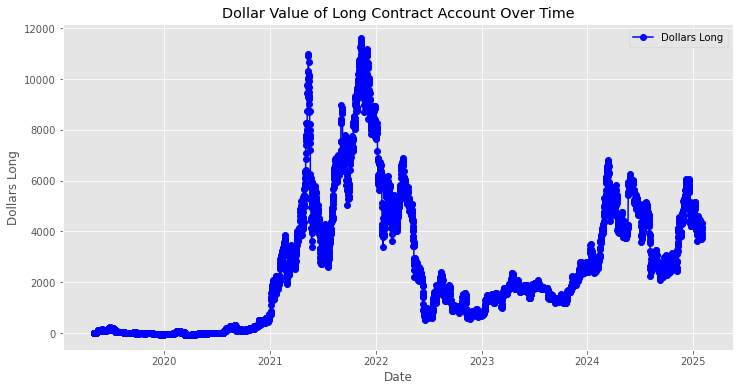

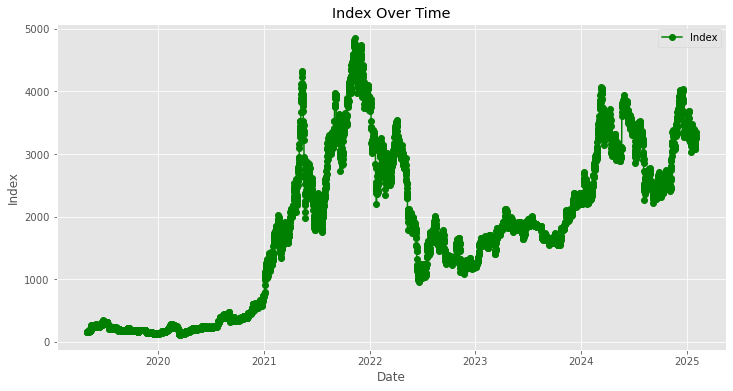

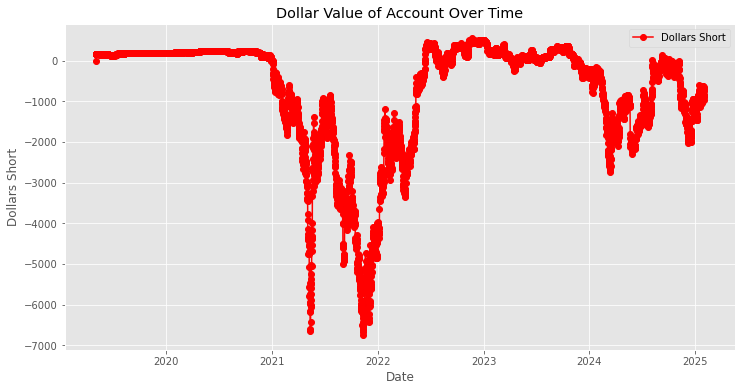

In [36]:
# Plot dollars_long
plt.figure(figsize=(12, 6))
plt.plot(stats.index, stats['dollars_long'], label='Dollars Long', color='blue', linestyle='-', marker='o')
plt.xlabel('Date')
plt.ylabel('Dollars Long')
plt.title('Dollar Value of Long Contract Account Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Index
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['index'], label='Index', color='green', linestyle='-', marker='o')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Index Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot dollars_short
plt.figure(figsize=(12, 6))
plt.plot(stats.index, stats['dollars_short'], label='Dollars Short', color='red', linestyle='-', marker='o')
plt.xlabel('Date')
plt.ylabel('Dollars Short')
plt.title('Dollar Value of Account Over Time')
plt.legend()
plt.grid(True)
plt.show()
